In [1]:
import tensorflow as tf

In [2]:
import pandas as pd
import os
import numpy as np
from keras_preprocessing import image as im
tf.random.set_seed(
    5
)

# Loading data

In [3]:
def load_data(image_path, annotations_path):
    df = pd.read_csv(annotations_path)
    df = df[~df['human_sentiment'].isna()]
    in_folder = os.listdir(image_path)
    df.loc[df['image_name'].isin(in_folder), 'image_name'] = \
    df.loc[df['image_name'].isin(in_folder), 'image_name'].apply(lambda x: os.path.join(image_path,x))
    images = []
    for image_name in df['image_name'].values:
        images.append(np.array(im.load_img(image_name, target_size=(224,224))))
    images = np.array(images)
    images = images/255
    annotations = df['annotation'].str.lower().values
    return images, annotations

In [4]:
images, annotations = load_data("../../../images/", '../../../emo-at-cap.csv')

# Processing of data

In [5]:
import nltk

In [6]:
tokenizer = nltk.tokenize.WordPunctTokenizer()

In [7]:
tokenized = [tokenizer.tokenize(i) for i in annotations]

In [8]:
unique_tokens, unique_counts = np.unique(np.hstack(tokenized), return_counts=True)

In [9]:
sorted(list(zip(unique_tokens, unique_counts)), key = lambda x: x[1])[::-1][:50]

[('the', 3261),
 ('is', 2031),
 ('man', 1905),
 ('and', 1536),
 ('woman', 1361),
 ('are', 1036),
 ('a', 963),
 ('to', 891),
 ('looks', 751),
 ('happy', 705),
 ('with', 547),
 ('something', 480),
 ('men', 478),
 ('of', 463),
 ('two', 408),
 ('other', 361),
 ('people', 343),
 ('couple', 334),
 (',', 330),
 ('in', 278),
 ('look', 270),
 ('because', 265),
 ('they', 256),
 ('about', 247),
 ('on', 246),
 ('at', 192),
 ('trying', 190),
 ('serious', 189),
 ('women', 184),
 ('each', 179),
 ('together', 176),
 ('by', 175),
 ('having', 171),
 ('flirting', 165),
 ('he', 155),
 ('smiling', 151),
 ('arguing', 141),
 ('angry', 140),
 ('scared', 138),
 ('worried', 137),
 ('hugging', 135),
 ('surprised', 134),
 ('calm', 133),
 ('company', 131),
 ('her', 129),
 ('group', 123),
 ('for', 121),
 ('she', 117),
 ('looking', 117),
 ('his', 115)]

In [10]:
len(unique_tokens)

2162

In [11]:
pad_token = '<PAD>'
start_token = '<S>'
end_token = '<E>'

In [12]:
vocab = dict(zip(unique_tokens,list(range(3,len(unique_tokens)+3))))
vocab[pad_token] = 0
vocab[start_token] = 1
vocab[end_token] = 2

In [13]:
inverse_vocab = dict([(v,k) for k,v in vocab.items()])

In [14]:
add_special_tokens = lambda x: [start_token] + x + [end_token]

In [15]:
tokenized = list(map(add_special_tokens,tokenized))

In [16]:
max_len = len(max(tokenized, key=len))

In [17]:
indexed = list(map(lambda x: [vocab[i] for i in x],tokenized))

In [19]:
padded = tf.keras.preprocessing.sequence.pad_sequences(indexed, truncating='post', maxlen=10)

In [20]:
images.shape

(3840, 224, 224, 3)

# Simple model without additional features, transfer learning and attention

In [23]:
def calc_size(x, f, s, padding='same'):
    p = 2 if padding=='same' else 1
    return (x-f+2)/s+1

### Convolutional model

In [72]:
class ConvEncoder(tf.keras.Model):
    def __init__(self, image_shape=(224,224,3)):
        super(ConvEncoder, self).__init__()
        self.input_conv = tf.keras.layers.Conv2D(filters=128, kernel_size=7, input_shape=image_shape, activation='relu',
                           padding='same', name='input_conv', strides=(1,1))
        self.conv1 = tf.keras.layers.Conv2D(filters=64, kernel_size=7, activation='relu',
                               padding='same', name='conv1', strides=(2,2))
        self.batch_norm1 =  tf.keras.layers.BatchNormalization()

        self.conv2 = tf.keras.layers.Conv2D(filters=32, kernel_size=5, activation='relu',
                               padding='same', name='conv2', strides=(2,2))
        self.batch_norm2 =  tf.keras.layers.BatchNormalization()

        self.conv3 = tf.keras.layers.Conv2D(filters=16, kernel_size=5, activation='relu',
                               padding='same', name='conv3', strides=(2,2))
        self.batch_norm3 =  tf.keras.layers.BatchNormalization()

        self.conv4 = tf.keras.layers.Conv2D(filters=8, kernel_size=3, activation='relu',
                               padding='same', name='conv4', strides=(2,2))
        self.batch_norm4 =  tf.keras.layers.BatchNormalization()

        self.conv5 = tf.keras.layers.Conv2D(filters=5, kernel_size=3, activation='relu',
                               padding='same', name='conv5', strides=(2,2))
        self.batch_norm5 =  tf.keras.layers.BatchNormalization()
        self.conv6 = tf.keras.layers.Conv2D(filters=5, kernel_size=3, activation='relu',
                               padding='same', name='conv5', strides=(2,2))
        self.batch_norm6 =  tf.keras.layers.BatchNormalization()
       
        self.flatten = tf.keras.layers.Flatten(name='final_code')
    
    def call(self, input):
        conv1_out = self.batch_norm1(self.conv1(self.input_conv(input)))
        conv2_out = self.batch_norm2(self.conv2(conv1_out))
        conv3_out = self.batch_norm3(self.conv3(conv2_out))
        conv4_out = self.batch_norm4(self.conv4(conv3_out))
        conv5_out = self.batch_norm5(self.conv5(conv4_out))
        conv6_out = self.batch_norm6(self.conv6(conv4_out))
        result = [self.flatten(conv5_out),self.flatten(conv6_out)]
        return result

In [73]:
conv_encoder = ConvEncoder()

In [74]:
conv_res = conv_encoder(np.expand_dims(images[0],axis=0))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [75]:
conv_res

[<tf.Tensor: shape=(1, 245), dtype=float32, numpy=
 array([[0.        , 0.00925779, 0.        , 0.        , 0.        ,
         0.        , 0.00581389, 0.        , 0.        , 0.        ,
         0.        , 0.00755592, 0.        , 0.        , 0.        ,
         0.        , 0.00108987, 0.        , 0.        , 0.        ,
         0.        , 0.01352532, 0.        , 0.        , 0.        ,
         0.        , 0.01224431, 0.        , 0.        , 0.        ,
         0.00383024, 0.00615112, 0.        , 0.        , 0.        ,
         0.        , 0.00879492, 0.        , 0.        , 0.        ,
         0.        , 0.01355776, 0.        , 0.        , 0.        ,
         0.        , 0.0151218 , 0.        , 0.        , 0.        ,
         0.        , 0.01196808, 0.        , 0.        , 0.        ,
         0.        , 0.0107857 , 0.        , 0.        , 0.        ,
         0.        , 0.02692535, 0.        , 0.        , 0.        ,
         0.        , 0.0110679 , 0.00031736, 0.     

### LSTM model

In [76]:
class LSTMDecoder(tf.keras.Model):
    def __init__(self, max_tokens, lstm_units, embeddings=None):
        super(LSTMDecoder, self).__init__()
        if not (embeddings is None):
            self.embeddings = tf.keras.layers.Embedding(input_dim=max_tokens+1, output_dim=128, name='embeddings',
                                                   weights=[embeddings])
        else:
            self.embeddings = tf.keras.layers.Embedding(input_dim=max_tokens+1, output_dim=128, name='embeddings'
                                                   )
        self.layer_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6, name='layer_normalization')
        self.lstm = tf.keras.layers.LSTM(units=lstm_units, return_state=True, name='lstm_decoder')
        self.output_dense = tf.keras.layers.Dense(units=max_tokens)
        
    def call(self, input, features):
        embedded = self.embeddings(input)
        result_lstm, state_h, state_c = self.lstm(embedded, initial_state=features)
        normalized = self.layer_norm(result_lstm)
        logits = self.output_dense(normalized)
        return logits, [state_h, state_c]

In [77]:
lstm_decoder = LSTMDecoder(len(inverse_vocab), conv_res[0].shape[1])

In [78]:
lstm_decoder(np.expand_dims(padded[0],axis=0), conv_res)

(<tf.Tensor: shape=(1, 2165), dtype=float32, numpy=
 array([[ 0.72209686,  0.10947791, -0.4856441 , ...,  0.7244562 ,
          0.457663  , -0.4473145 ]], dtype=float32)>,
 [<tf.Tensor: shape=(1, 245), dtype=float32, numpy=
  array([[ 3.9798813e-03, -3.9558788e-03, -2.2967928e-03, -4.7289380e-03,
          -7.3734904e-03,  1.3083889e-03, -1.7672551e-03,  1.2657270e-03,
          -2.8558457e-03, -9.6940594e-03,  3.2105439e-03,  4.2707757e-03,
          -6.0662110e-03,  2.7365691e-03, -5.2783743e-04,  5.7736142e-03,
           4.7311981e-04, -1.4969356e-03, -6.0037425e-04, -1.0328615e-02,
           4.1627360e-04,  5.0492524e-03, -8.3535854e-03, -1.0654777e-03,
          -3.5064272e-03, -1.7493282e-03,  8.1845848e-03, -3.1847809e-03,
          -7.2829041e-04, -1.9935521e-03, -7.4089778e-04, -3.7494728e-03,
          -2.9267566e-03, -3.5956618e-03,  9.5683633e-04,  4.4316705e-03,
           3.8738865e-03,  2.2017171e-03, -4.8693838e-03, -1.7357658e-03,
          -2.7984421e-04, -4.0787957

### Training

In [79]:
from sklearn.model_selection import train_test_split

In [80]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none',
                                                                         from_logits=True)
lr_value = 1e-3
reduction_power = 10
optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_value)


In [81]:
epochs = 30
batch_size = 64
patience_epochs = 2

In [82]:
def loss_function(real, pred):
        mask = tf.math.logical_not(tf.math.equal(real, vocab[pad_token]))
        loss_ = loss_object(real, pred)

        mask = tf.cast(mask, dtype=loss_.dtype)
        loss_ *= mask
        return loss_

In [83]:
@tf.function
def train_step(image, target, lengths, optimizer):

    with tf.GradientTape() as tape:
        initial_state = conv_encoder(image)
        # Teacher forcing - feeding the target as the next input
        batched_loss = []
        for t in range(1, target.shape[1]):
            
            dec_input = tf.expand_dims(target[:, t-1], 1)
            result, initial_state = lstm_decoder(input=dec_input, features=initial_state)

            batched_loss.append(loss_function(target[:, t], result))
        batched_loss = tf.reshape(tf.stack(batched_loss), shape=target[:,1:].shape)
        batched_loss = tf.reduce_sum(batched_loss, axis=1)
        lengths = tf.cast(lengths, dtype=batched_loss.dtype)
        loss = tf.reduce_mean(batched_loss / lengths)

    perplexity = tf.exp(loss)

    variables = conv_encoder.trainable_variables + lstm_decoder.trainable_variables
    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return loss, perplexity

In [84]:
@tf.function
def evaluate(image, target, lengths, optimizer):

    initial_state = conv_encoder(image)
    # Teacher forcing - feeding the target as the next input
    batched_loss = []
    for t in range(1, target.shape[1]):

        dec_input = tf.expand_dims(target[:, t-1], 1)
        result, initial_state = lstm_decoder(input=dec_input, features=initial_state)

        batched_loss.append(loss_function(target[:, t], result))

    batched_loss = tf.reshape(tf.stack(batched_loss), shape=target[:,1:].shape)
    batched_loss = tf.reduce_sum(batched_loss, axis=1)
    lengths = tf.cast(lengths, dtype=batched_loss.dtype)
    loss = tf.reduce_mean(batched_loss / lengths)

    perplexity = tf.exp(loss)


    return loss, perplexity

In [37]:
train_images, test_images, train_sequences, test_sequences =  train_test_split(images, padded, test_size=0.1, random_state=9)

In [38]:
train_length = (train_sequences!=vocab[pad_token]).sum(axis=1)-2

In [39]:
test_length = (test_sequences!=vocab[pad_token]).sum(axis=1)-2

In [40]:
train_images = np.array(np.array_split(train_images, len(train_images)//batch_size))
test_images = np.array(np.array_split(test_images, len(test_images)//batch_size))
train_sequences = np.array(np.array_split(train_sequences, len(train_sequences)//batch_size))
test_sequences = np.array(np.array_split(test_sequences, len(test_sequences)//batch_size))
train_length = np.array(np.array_split(train_length, len(train_length)//batch_size))
test_length = np.array(np.array_split(test_length, len(test_length)//batch_size))

In [41]:
train_images.shape, train_sequences.shape, train_length.shape

((54, 64, 224, 224, 3), (54, 64, 10), (54, 64))

In [42]:
!pip install tqdm

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [43]:
from tqdm import tqdm

In [85]:
train_loss = []
train_perplexity = []
test_loss = []
test_perplexity = []
overfit_epochs = 0
for epoch in range(epochs):
    epoch_train_loss = 0
    epoch_train_perplexity = 0
    epoch_test_loss = 0
    epoch_test_perplexity = 0
    for batch_train_images, batch_train_sequences, batched_train_length in tqdm(zip(train_images,train_sequences,train_length)):
        batched_train_loss, batched_train_perplexity = train_step(batch_train_images,batch_train_sequences,batched_train_length, optimizer)
        epoch_train_loss+=batched_train_loss
        epoch_train_perplexity+=batched_train_perplexity
    epoch_train_loss = epoch_train_loss/train_images.shape[0]
    epoch_train_perplexity = epoch_train_perplexity/train_images.shape[0]
    train_loss.append(epoch_train_loss)
    train_perplexity.append(epoch_train_perplexity)
    print('Finished epoch {}; Train loss : {}; Train perplexity : {}'.format(epoch,epoch_train_loss,epoch_train_perplexity))
    for batch_test_images, batch_test_sequences, batched_test_length in zip(test_images,test_sequences,test_length):
        batched_test_loss, batched_test_perplexity = evaluate(batch_test_images,batch_test_sequences,batched_test_length, optimizer)
        epoch_test_loss+=batched_test_loss
        epoch_test_perplexity+=batched_test_perplexity
    epoch_test_loss = epoch_test_loss/test_images.shape[0]
    epoch_test_perplexity = epoch_test_perplexity/test_images.shape[0]
    test_perplexity.append(epoch_test_perplexity)
    test_loss.append(epoch_test_loss)
    print('Test loss : {}; Test perplexity : {}'.format(epoch_test_loss,epoch_test_perplexity))
    if len(test_loss)>=2 and test_loss[-2]<test_loss[-1]:
        overfit_epochs+=1
    else:
        overfit_epochs=0
    if overfit_epochs==patience_epochs:
        lr_value/=reduction_power
        optimizer.lr.assign(lr_value)
        print('There was no improvement in test loss for {} epochs, thus reducing learning rate'.format(patience_epochs))

54it [01:31,  1.70s/it]


Finished epoch 0; Train loss : 5.06287956237793; Train perplexity : 636.5866088867188


0it [00:00, ?it/s]

Test loss : 3.7991340160369873; Test perplexity : 45.26715087890625


54it [01:19,  1.46s/it]


Finished epoch 1; Train loss : 3.353914499282837; Train perplexity : 29.70578956604004


0it [00:00, ?it/s]

Test loss : 3.3247182369232178; Test perplexity : 28.175100326538086


54it [01:19,  1.46s/it]


Finished epoch 2; Train loss : 2.922825336456299; Train perplexity : 18.987449645996094


0it [00:00, ?it/s]

Test loss : 3.223586082458496; Test perplexity : 25.459749221801758


54it [01:17,  1.44s/it]


Finished epoch 3; Train loss : 2.6853578090667725; Train perplexity : 14.874757766723633


0it [00:00, ?it/s]

Test loss : 3.162283182144165; Test perplexity : 23.908315658569336


54it [01:18,  1.45s/it]


Finished epoch 4; Train loss : 2.512219190597534; Train perplexity : 12.472403526306152


0it [00:00, ?it/s]

Test loss : 3.1606128215789795; Test perplexity : 23.877851486206055


54it [01:17,  1.44s/it]


Finished epoch 5; Train loss : 2.3761279582977295; Train perplexity : 10.870580673217773


0it [00:00, ?it/s]

Test loss : 3.1588780879974365; Test perplexity : 23.8465633392334


54it [01:18,  1.46s/it]


Finished epoch 6; Train loss : 2.2554593086242676; Train perplexity : 9.614973068237305


0it [00:00, ?it/s]

Test loss : 3.2216079235076904; Test perplexity : 25.36094856262207


54it [01:19,  1.47s/it]


Finished epoch 7; Train loss : 2.150676965713501; Train perplexity : 8.651745796203613


0it [00:00, ?it/s]

Test loss : 3.192761182785034; Test perplexity : 24.683212280273438


54it [01:18,  1.45s/it]


Finished epoch 8; Train loss : 2.056351900100708; Train perplexity : 7.867663860321045


0it [00:00, ?it/s]

Test loss : 3.2263848781585693; Test perplexity : 25.511945724487305


38it [00:55,  1.47s/it]


KeyboardInterrupt: 

# Viewing and saving results

In [49]:
df = pd.DataFrame()
model_name = 'conv_lstm'
df['train_perplexity_{}'.format(model_name)] = [i.numpy() for i in train_perplexity]
df['test_perplexity_{}'.format(model_name)] = [i.numpy() for i in test_perplexity]
df['train_loss_{}'.format(model_name)] = [i.numpy() for i in train_loss]
df['test_loss_{}'.format(model_name)] = [i.numpy() for i in test_loss]
df.to_csv('{}_logs.csv'.format(model_name),index=False)

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

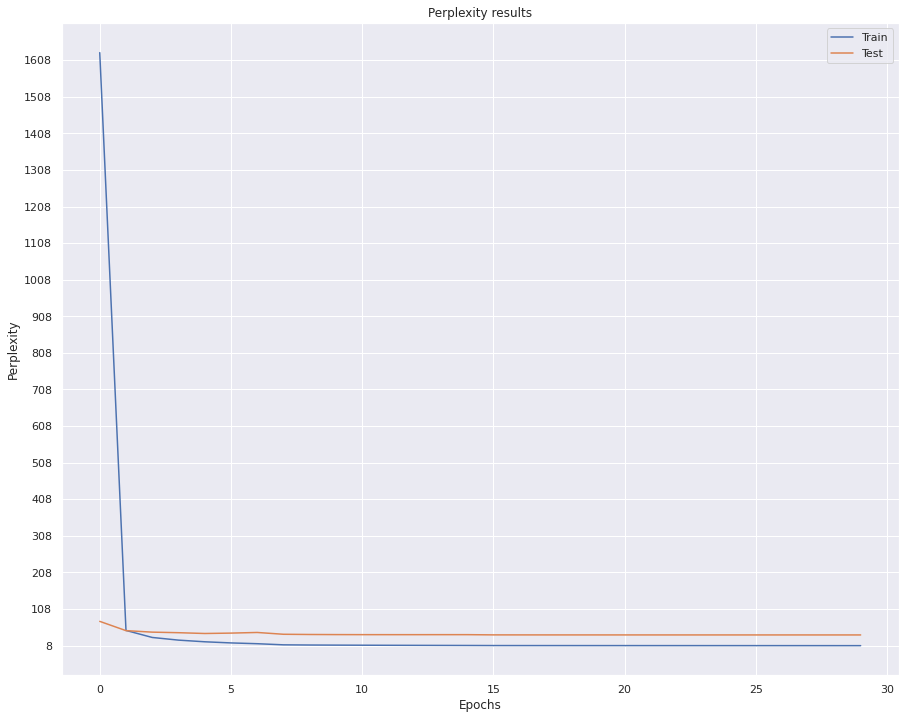

In [51]:
plt.figure(figsize=(15,12))
plt.title('Perplexity results')
plt.plot(df['train_perplexity_{}'.format(model_name)])
plt.plot(df['test_perplexity_{}'.format(model_name)])
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.yticks(np.arange(min(df['train_perplexity_{}'.format(model_name)]), max(df['train_perplexity_{}'.format(model_name)]),100))
plt.legend(['Train', 'Test']);

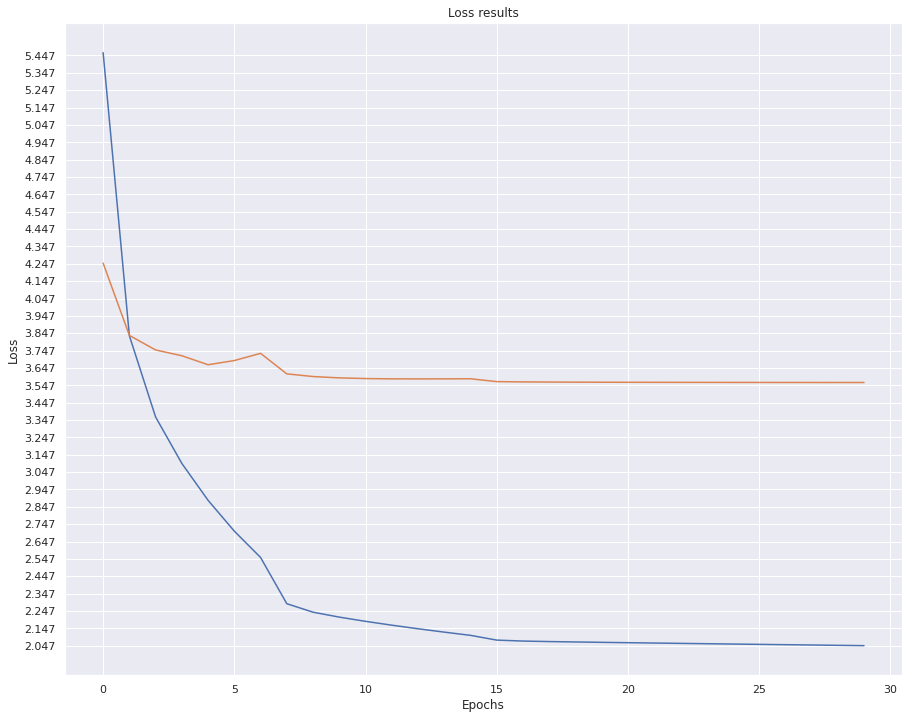

In [52]:
plt.figure(figsize=(15,12))
plt.title('Loss results')
plt.plot(df['train_loss_{}'.format(model_name)])
plt.plot(df['test_loss_{}'.format(model_name)])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yticks(np.arange(min(df['train_loss_{}'.format(model_name)]),max(df['train_loss_{}'.format(model_name)]),0.1));

# Testing model

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

In [86]:
class Decoder:
    def __init__(self, encoder: tf.keras.Model,
                 decoder: tf.keras.Model,
                 start_token: int,
                 end_token: int,
                 max_len: int = 10, ):
        self.encoder = encoder
        self.decoder = decoder
        self.max_len = max_len
        self.start_token = start_token
        self.end_token = end_token

    def decode(self, input):
        pass


class GreedyDecoder(Decoder):
    def __init__(self, encoder: tf.keras.Model,
                 decoder: tf.keras.Model,
                 start_token: int,
                 end_token: int,
                 max_len: int = 10,
                 ):
        super().__init__(encoder,
                         decoder,
                         start_token,
                         end_token,
                         max_len
                         )

    def decode(self, input, max_len_output=50):
        initial_state = self.encoder(np.expand_dims(input, axis=0))

        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = self.start_token

        res = []
        while True:
            # Sample a token
            output, initial_state = self.decoder(target_seq,initial_state)
            sampled_token_index = np.argmax(output)

            if len(res) > max_len_output or sampled_token_index == self.end_token:
                break

            res.append(sampled_token_index)

            target_seq = np.zeros((1, 1))
            target_seq[0, 0] = sampled_token_index

       
        return res


In [87]:
class BeamSearchDecoder(Decoder):
    def __init__(self, encoder: tf.keras.Model,
                 decoder: tf.keras.Model,
                 start_token: int,
                 end_token: int,
                 max_len: int = 10,
                 ):
        super().__init__(encoder,
                         decoder,
                         start_token,
                         end_token,
                         max_len
                         )

    def decode(self, input, beam_size=3):
        start = [self.start_token]
        initial_state = self.encoder(np.expand_dims(input,axis=0))


        start_word = [[start, 0.0, initial_state]]

        while len(start_word[0][0]) < self.max_len:
            temp = []
            for s in start_word:
                target_seq = np.array([[s[0][-1]]])
                initial_state = s[-1]
                output, initial_state= self.decoder(target_seq, initial_state)
                output = np.hstack(output)
                output = tf.nn.softmax(output).numpy()
                word_preds = np.argsort(output)[-beam_size:]

                for w in word_preds:
                    next_cap, prob = s[0][:], s[1]
                    next_cap.append(w)
                    prob += output[w]
                    temp.append([next_cap, prob, initial_state])

            start_word = temp
            # Sorting according to the probabilities
            start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
            # Getting the top words
            start_word = start_word[-beam_size:]

        start_word = start_word[-1][0]

        final_caption = []

        for i in start_word:
            if i != self.end_token:
                final_caption.append(i)
            else:
                break
        return final_caption[1:]

In [88]:
def predict(data, decoder, inverse_vocab,
           beam_size=None):
    if beam_size:
        result = decoder.decode(data, beam_size=beam_size)
    else:
        result = decoder.decode(data)
    return ' '.join([inverse_vocab[i] for i in result])

In [89]:
greedy_decoder = GreedyDecoder(conv_encoder, lstm_decoder, vocab[start_token], vocab[end_token],
             max_len=39)

In [90]:
beam_decoder = BeamSearchDecoder(conv_encoder, lstm_decoder, vocab[start_token], vocab[end_token],
             max_len=39)

In [91]:
images.shape

(3840, 224, 224, 3)

In [108]:
sample = np.random.choice(range(len(images)))
sample = images[sample]

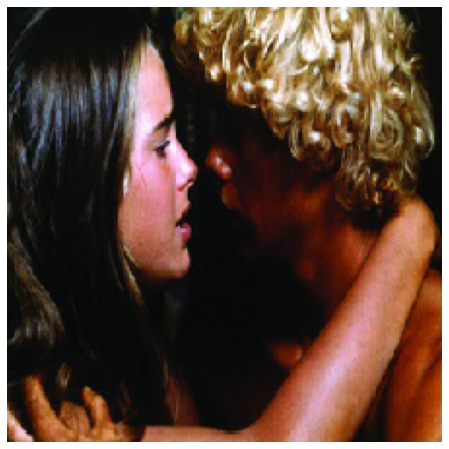

In [109]:
plt.figure(figsize=(8,8))
plt.imshow(sample)
plt.grid([])
plt.axis('off');

In [110]:
predict(sample, greedy_decoder, inverse_vocab)

'the man is arguing with the other man'

In [111]:
predict(sample, beam_decoder, inverse_vocab, beam_size=4)

'the man is trying to harm the other man'

# Blue score calculation

In [72]:
from nltk.translate.bleu_score import sentence_bleu


### making predictions on test dataset with beam_size of 5

In [73]:
test_predictions = []
for batch in tqdm(test_images):
    for image in batch:
        result = predict(image, beam_decoder, inverse_vocab, beam_size=5)
        test_predictions.append(result)

100%|██████████| 6/6 [06:51<00:00, 68.57s/it]


In [74]:
test_predictions = [i.split(' ') for i in test_predictions]

In [75]:
reshaped_sequences = test_sequences.reshape(test_sequences.shape[0]*test_sequences.shape[1],-1)

In [76]:
test_sentences = []
for i in reshaped_sequences:
    tmp = []
    for word in i:
        if word!=0 and word!=1 and word!=2:
            tmp.append(inverse_vocab[word])
    test_sentences.append(tmp)

In [77]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu(reference, prediction, weights=(0.5,0.5)))
print('Bleu score on test data : {}'.format(np.mean(bleu_score)))

Bleu score on test data : 2.7936917791942035e-155


/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


### making predictions on test dataset with beam_size of 10

In [93]:
test_predictions = []
for batch in tqdm(test_images):
    for image in batch:
        result = predict(image, beam_decoder, inverse_vocab, beam_size=10)
        test_predictions.append(result)

100%|██████████| 6/6 [13:58<00:00, 139.70s/it]


In [94]:
test_predictions = [i.split(' ') for i in test_predictions]

In [95]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu(reference, prediction))
print('Bleu score on test data : {}'.format(np.mean(bleu_score)))

Bleu score on test data : 4.368370909805482e-232
